In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
df = pd.read_csv('/content/DATA.csv')

In [3]:
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [4]:
df.isnull().sum()

,0
Unnamed: 0,0
statement,362
status,0


In [5]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
df.dropna(inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52681 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     52681 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [8]:
df.shape

(52681, 2)

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64


<ipython-input-9-cdfdf56263b9>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=status_counts.index, y=status_counts.values, palette="viridis")


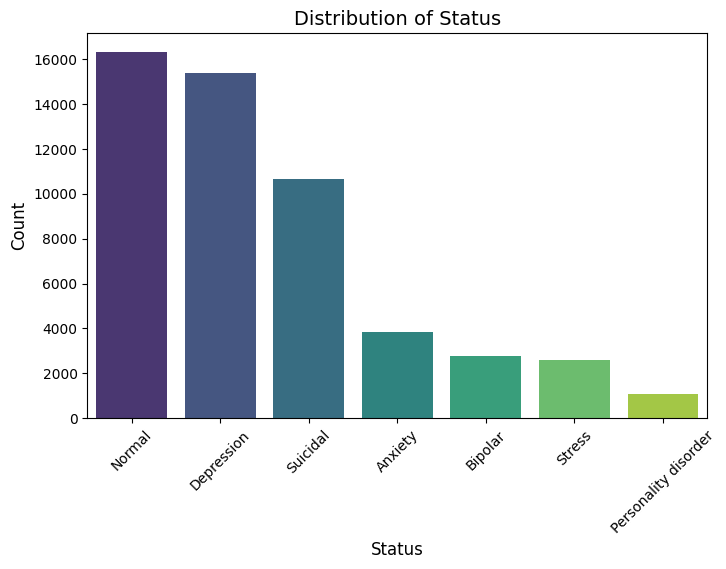

In [9]:
print(df['status'].value_counts())


# Get value counts
status_counts = df['status'].value_counts()

# Plot bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=status_counts.index, y=status_counts.values, palette="viridis")

# Labels and title
plt.xlabel("Status", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Status", fontsize=14)
plt.xticks(rotation=45)  # Rotate labels if needed

# Show plot
plt.show()

In [10]:
df['status'].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

In [11]:
classes = np.array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar', 'Personality disorder'])

In [12]:
def transform_class(class_name):
    return np.where(classes == class_name)[0][0]  # Return class index instead of one-hot vector

def rev_transform_class(class_idx):
    return classes[class_idx]  # Get class label from index

In [13]:
x_train, x_test, y_train, y_test = train_test_split(df['statement'].values, df['status'].values, random_state=42, test_size=0.2)

In [14]:
# Tokenization
tokenizer = Tokenizer(oov_token='UNK', lower=True)
tokenizer.fit_on_texts(x_train)

In [15]:
x_train_tokenized = tokenizer.texts_to_sequences(x_train)
x_test_tokenized = tokenizer.texts_to_sequences(x_test)

In [16]:
max_len = max([len(x) for x in x_train_tokenized])
x_train_tokenized_padded = pad_sequences(x_train_tokenized, maxlen=max_len)
x_test_tokenized_padded = pad_sequences(x_test_tokenized, maxlen=max_len)

# Convert labels to indices (not one-hot)
y_train = np.array([transform_class(y) for y in y_train])
y_test = np.array([transform_class(y) for y in y_test])

In [17]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        x = torch.tensor(self.x[idx], dtype=torch.long)  # Convert to tensor
        y = torch.tensor(self.y[idx], dtype=torch.long)  # Return index instead of one-hot
        return x, y

In [18]:
batch_size = 24
train_dataloader = DataLoader(CustomDataset(x_train_tokenized_padded, y_train), shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(CustomDataset(x_test_tokenized_padded, y_test), shuffle=False, batch_size=batch_size)

In [19]:
class Model(nn.Module):
    def __init__(self, vocab_size, embedding_size, num_hidden, num_lstm, num_classes):
        super().__init__()
        self.embd = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.lstm = nn.LSTM(embedding_size, num_hidden, bidirectional=True, num_layers=num_lstm, batch_first=True)
        self.linear = nn.Linear(2 * num_hidden * max_len, num_classes)

    def forward(self, x):
        x = self.embd(x)
        x, _ = self.lstm(x)
        x = x.flatten(start_dim=1)  # Flatten LSTM output
        x = self.linear(x)
        return x  # No activation here (CrossEntropyLoss includes softmax)

In [20]:
# Model Initialization
vocab_size = len(tokenizer.word_index) + 1
embedding_size = 64
num_hidden = 64
num_lstm = 1
num_classes = len(classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(vocab_size, embedding_size, num_hidden, num_lstm, num_classes).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()  # No need for one-hot encoding
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-2, weight_decay=1e-4)

In [22]:
epochs = 10
avg_loss = []
avg_acc = []

In [23]:
for e in range(epochs):
    print(f'\nEpoch {e+1}/{epochs}')
    acc = 0
    loss_acc = 0
    n = 0
    model.train()

    for x, y in tqdm(train_dataloader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)

        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        op = pred.argmax(dim=1)  # Get class with highest probability
        acc += (op == y).sum().item()
        n += y.shape[0]
        loss_acc += loss.detach().item()

    avg_loss.append(loss_acc / len(train_dataloader))
    avg_acc.append(acc / n)

    print(f'Avg Loss: {avg_loss[-1]:.4f}, Avg Acc: {avg_acc[-1]:.4f}')


Epoch 1/10


100%|██████████| 1756/1756 [01:17<00:00, 22.64it/s]


Avg Loss: 1.7894, Avg Acc: 0.5963

Epoch 2/10


100%|██████████| 1756/1756 [01:18<00:00, 22.41it/s]


Avg Loss: 0.6500, Avg Acc: 0.7606

Epoch 3/10


100%|██████████| 1756/1756 [01:19<00:00, 22.00it/s]


Avg Loss: 0.5371, Avg Acc: 0.8080

Epoch 4/10


100%|██████████| 1756/1756 [01:20<00:00, 21.83it/s]


Avg Loss: 0.4659, Avg Acc: 0.8395

Epoch 5/10


100%|██████████| 1756/1756 [01:20<00:00, 21.90it/s]


Avg Loss: 0.4150, Avg Acc: 0.8598

Epoch 6/10


100%|██████████| 1756/1756 [01:20<00:00, 21.88it/s]


Avg Loss: 0.3758, Avg Acc: 0.8748

Epoch 7/10


100%|██████████| 1756/1756 [01:20<00:00, 21.93it/s]


Avg Loss: 0.3435, Avg Acc: 0.8885

Epoch 8/10


100%|██████████| 1756/1756 [01:20<00:00, 21.91it/s]


Avg Loss: 0.3172, Avg Acc: 0.8982

Epoch 9/10


100%|██████████| 1756/1756 [01:20<00:00, 21.87it/s]


Avg Loss: 0.2936, Avg Acc: 0.9069

Epoch 10/10


100%|██████████| 1756/1756 [01:20<00:00, 21.82it/s]

Avg Loss: 0.2725, Avg Acc: 0.9153


In [24]:
model.eval()
test_acc = 0
n_test = 0

with torch.no_grad():
    for x, y in test_dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        op = pred.argmax(dim=1)
        test_acc += (op == y).sum().item()
        n_test += y.shape[0]

print(f"\nTest Accuracy: {test_acc / n_test:.4f}")


Test Accuracy: 0.7463


# Inferencing

In [25]:
def preprocess_text(text, tokenizer, max_len):
    tokenized = tokenizer.texts_to_sequences([text])  # Tokenize
    padded = pad_sequences(tokenized, maxlen=max_len)  # Pad sequence
    return torch.tensor(padded, dtype=torch.long).to(device)  # Convert to tensor

In [26]:
def predict(text, model, tokenizer, max_len, index_to_class):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No gradient calculation needed
        input_tensor = preprocess_text(text, tokenizer, max_len)  # Preprocess text
        output = model(input_tensor)  # Get model output
        predicted_class_idx = torch.argmax(output, dim=1).item()  # Get class index
        predicted_class = index_to_class[predicted_class_idx]  # Convert to label
        return predicted_class

In [28]:
# Define class mapping (inverse of class_to_index)
index_to_class = {idx: cls for idx, cls in enumerate(classes)}

In [29]:
example_text = "I feel so stressed and overwhelmed with everything."
predicted_label = predict(example_text, model, tokenizer, max_len, index_to_class)
print(f"Predicted Class: {predicted_label}")

Predicted Class: Normal


In [30]:
test_samples = [
    "I feel so anxious all the time, my heart races and I can't focus.",  # Anxiety
    "Everything is fine, I have no issues at all.",  # Normal
    "I feel extremely low and have no motivation to do anything.",  # Depression
    "Life feels meaningless, and I keep having thoughts of ending it.",  # Suicidal
    "Work pressure is overwhelming, and I feel so stressed out.",  # Stress
    "I experience extreme mood swings from being super happy to very depressed.",  # Bipolar
    "I struggle to relate to people, and my emotions feel all over the place.",  # Personality disorder
]

In [31]:
for text in test_samples:
    predicted_label = predict(text, model, tokenizer, max_len, index_to_class)
    print(f"Text: {text}\nPredicted Class: {predicted_label}\n")

Text: I feel so anxious all the time, my heart races and I can't focus.
Predicted Class: Anxiety

Text: Everything is fine, I have no issues at all.
Predicted Class: Normal

Text: I feel extremely low and have no motivation to do anything.
Predicted Class: Depression

Text: Life feels meaningless, and I keep having thoughts of ending it.
Predicted Class: Depression

Text: Work pressure is overwhelming, and I feel so stressed out.
Predicted Class: Normal

Text: I experience extreme mood swings from being super happy to very depressed.
Predicted Class: Depression

Text: I struggle to relate to people, and my emotions feel all over the place.
Predicted Class: Normal



In [32]:
suicidal_samples = [
    "I feel like there's no point in continuing anymore.",
    "The pain is unbearable, and I just want it all to stop.",
    "No one would even notice if I was gone.",
    "I keep thinking about ways to end this suffering.",
    "I feel empty, hopeless, and like there's no way out.",
    "Lately, I've been thinking a lot about death and how peaceful it sounds.",
    "I don't see a future for myself anymore.",
]
for text in suicidal_samples:
    predicted_label = predict(text, model, tokenizer, max_len, index_to_class)
    print(f"Text: {text}\nPredicted Class: {predicted_label}\n")


Text: I feel like there's no point in continuing anymore.
Predicted Class: Suicidal

Text: The pain is unbearable, and I just want it all to stop.
Predicted Class: Suicidal

Text: No one would even notice if I was gone.
Predicted Class: Normal

Text: I keep thinking about ways to end this suffering.
Predicted Class: Normal

Text: I feel empty, hopeless, and like there's no way out.
Predicted Class: Normal

Text: Lately, I've been thinking a lot about death and how peaceful it sounds.
Predicted Class: Normal

Text: I don't see a future for myself anymore.
Predicted Class: Suicidal



# METRICS

In [33]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Set model to evaluation mode
model.eval()

# Store true labels and predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_dataloader:
        x, y = x.to(device), y.to(device)

        pred = model(x)
        op = pred.argmax(dim=1)  # Get predicted class index

        all_preds.extend(op.cpu().numpy())  # Move to CPU for sklearn
        all_labels.extend(y.cpu().numpy())

# Convert lists to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


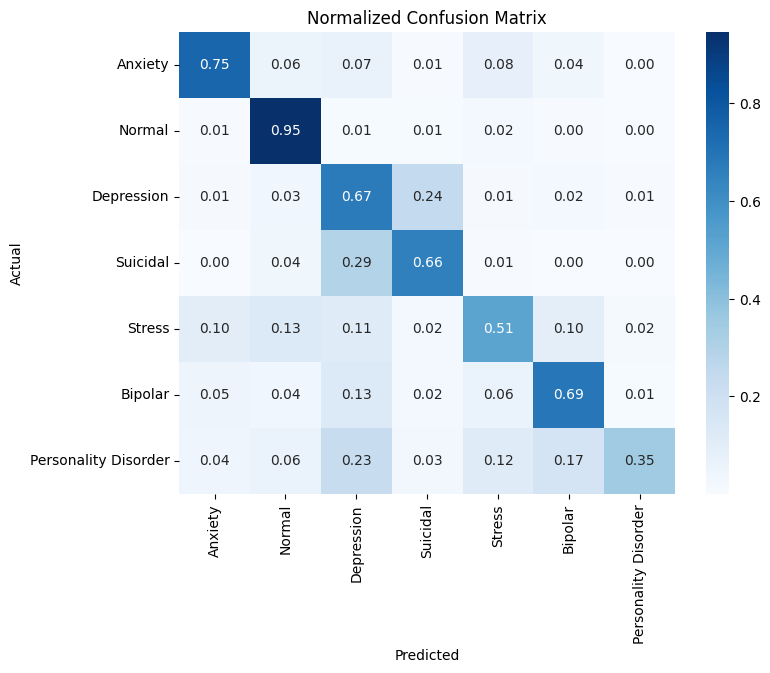


Classification Report:

                      precision    recall  f1-score   support

             Anxiety       0.79      0.75      0.77       755
              Normal       0.90      0.95      0.92      3308
          Depression       0.69      0.67      0.68      3016
            Suicidal       0.64      0.66      0.65      2158
              Stress       0.53      0.51      0.52       536
             Bipolar       0.64      0.69      0.66       527
Personality Disorder       0.67      0.35      0.46       237

            accuracy                           0.75     10537
           macro avg       0.69      0.65      0.67     10537
        weighted avg       0.74      0.75      0.74     10537



In [35]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Define class labels
class_labels = ['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar', 'Personality Disorder']

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Normalize the confusion matrix (row-wise normalization)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix")
plt.show()

# Print classification report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_labels))